<center style="font-size: 16px; font-weight: normal">
  `21 Microservices Architecture Patterns Study</center>

<center><h1>Chapter 3. Coupling and Abstractions</h1></center>

<center>
  Joseph Kim &lt;cloudeyes@gmail.com&gt;<br/>
  Dec 28. 2020<br/>
</center>

<center>
  <img src="https://images-na.ssl-images-amazon.com/images/I/51-q9CWNBHL._SX379_BO1,204,203,200_.jpg" style="width: 200px">
</center>

<center>
  <a href="https://github.com/cloudeyes/2021-msa-study/blob/main/03-coupling-and-abstractions/03-coupling-and-abstractions.ipynb">Download Jupyter Notebook</a>
</center>

## Introduction

TDD 문제 풀이 사이트  

- https://kata-log.rocks/tdd

리뷰

- https://www.programmingwithwolfgang.com/tdd-kata/


### Motivation

- what makes a good abstraction?
- What do we want from abstractions?
- And how do they relate to testing?

#### Global coupling is harmful

- Locally, coupling is a good thing: it’s a sign that our code is working together
  > "high cohesion" between the coupled elements.
- But, "globally" it harms maintainability
  - increasing the risk and the cost of changing our code
  - until we are no longer able to effectively change our systems.

#### Abstracting details fixes the coupling

**Lots of Coupling**

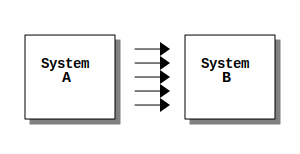

In [6]:
%%ditaa 
+--------+      +--------+
|        | ---> |        |
| System | ---> | System |
|   A    | ---> |   B    |
|        | ---> |        |
|        | ---> |        |
+--------+      +--------+

**Less Coupling**

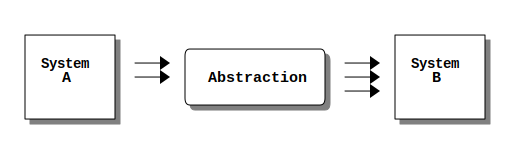

In [4]:
%%ditaa
+--------+                           +--------+
|        |      /-------------\      |        |
| System | ---> |             | ---> | System |
|   A    | ---> | Abstraction | ---> |   B    |
|        |      |             | ---> |        |
|        |      \-------------/      |        |
+--------+                           +--------+

## Abstracting state Aids Testability

### Example: synchronizing two directories

-  If a file "exists" in the source
  - **Rule 1:** then if it's not in the destination, copy the file over.
  - else it's in the destination but with a different name, 
    - **Rule 2:** rename the destination file to match.
- **Rule 3:** If a file exists in the destination but not in the source, remove it.

"Existence" of files should be checked by "hash value".

#### 1. "Hashing" a file to check identity

Generate a SHA-1 hash from a file to compare files.

In [118]:
BLOCKSIZE = 65536
from pathlib import Path
import hashlib

def hash_file(path: Path) -> str:
    hasher = hashlib.sha1()
    with path.open("rb") as file:
        buf = file.read(BLOCKSIZE)
        while buf:
            hasher.update(buf)
            buf = file.read(BLOCKSIZE)
    return hasher.hexdigest()

In [119]:
@test
def test_hash_file():
    import os
    os.makedirs('./build', exist_ok=True)
    inpath  = Path('03-coupling-and-abstractions.ipynb')
    outpath = Path('./build') / inpath
    
    with open(inpath) as fin:
        with open(outpath, 'w+') as fout:
            fout.write(fin.read())
            
    print(h1 := hash_file(inpath))
    assert h1 == hash_file(outpath) 

166f24cae6cc78c40819d6822b1e684edb715317
✅ test_hash_file


#### 2. Basic sync algorithm

Implement the business logic in this way:
- Start with a solution to the smallest part of the problem.
- And then iteratively make the solution richer and better designed.

##### Make a sample test files

In [120]:
!rm -rf tests/ex1 \
&& mkdir -p tests/ex1/{source,target} \
&& echo "I am a very useful file" > tests/ex1/source/my-file \
&& echo "I am a special file" > tests/ex1/source/special-file \
&& echo "You are a very useful file" > tests/ex1/target/your-file \
&& echo "I am a very useful file" > tests/ex1/target/renamed-my-file \
&& tree tests/ex1

tests/ex1
├── source
│   ├── my-file
│   └── special-file
└── target
    ├── renamed-my-file
    └── your-file

2 directories, 4 files


##### Create a test first that fails

In [138]:
def sync(source: str, dest: str) -> None:
    raise NotImplementedError

@test
def test_when_a_file_exists_in_the_source_but_not_the_destination():
    sync('tests/ex1/source', 'tests/ex1/target')

Traceback (most recent call last):
  File "<ipython-input-138-78acc283b242>", line 2, in sync
    raise NotImplementedError
NotImplementedError


##### Play with Jupyter notebook to build some scaffolds

In [122]:
for folder, dirs, files in os.walk('tests/ex1'): print(folder, _, files)

tests/ex1 [] []
tests/ex1/source [] ['special-file', 'my-file']
tests/ex1/target [] ['renamed-my-file', 'your-file']


In [123]:
src_path = Path('./tests/ex1/source')
dst_path = Path('./tests/ex1/target')

def hash_files(path: Path(folder)) -> dict[str, str]:
    hashes = dict[str, str]()

    for folder, _, files in os.walk(path):
        for fname in files:
            hashes[hash_file(Path(folder) / fname)] = fname

    return hashes

src_hashes, dst_hashes = hash_files(source_path), hash_files(target_path)
src_hashes, dst_hashes

({'82133f2e33bcea9bbadf74c5e2438e5e0db07a33': 'special-file',
  '4a17979d33f38b7c36e38a6b02013b2f2ef01fbb': 'my-file'},
 {'4a17979d33f38b7c36e38a6b02013b2f2ef01fbb': 'renamed-my-file',
  '197f216e99637a19a46c44ea849b4bb493e92275': 'your-file'})

In [124]:
src_keys, dst_keys = src_hashes.keys(), dst_hashes.keys()
src_keys, dst_keys

(dict_keys(['82133f2e33bcea9bbadf74c5e2438e5e0db07a33', '4a17979d33f38b7c36e38a6b02013b2f2ef01fbb']),
 dict_keys(['4a17979d33f38b7c36e38a6b02013b2f2ef01fbb', '197f216e99637a19a46c44ea849b4bb493e92275']))

In [125]:
src_only = src_keys - dst_keys; src_only

{'82133f2e33bcea9bbadf74c5e2438e5e0db07a33'}

In [126]:
dst_only = dst_keys - src_keys; dst_only

{'197f216e99637a19a46c44ea849b4bb493e92275'}

In [127]:
in_both = src_keys & dst_keys; in_both

{'4a17979d33f38b7c36e38a6b02013b2f2ef01fbb'}

##### Implement business rules

**Rule 1**: Copy a file from to destination if the file exists **only** in the source.

In [128]:
!tree tests/ex1

tests/ex1
├── source
│   ├── my-file
│   └── special-file
└── target
    ├── renamed-my-file
    └── your-file

2 directories, 4 files


In [129]:
import shutil

for key in src_only:
    file_name = src_hashes[key]
    src_file_path = src_path / file_name
    dst_file_path = dst_path / file_name
    shutil.copy(src_file_path, dst_file_path)

`special-file` should be copied to `target` folder.

In [130]:
!tree tests/ex1

tests/ex1
├── source
│   ├── my-file
│   └── special-file
└── target
    ├── renamed-my-file
    ├── special-file
    └── your-file

2 directories, 5 files


**Rule 3**: Remove a file from destination if it's not in the source, 

In [131]:
for key in dst_only:
    file_name = dst_hashes[key]
    dst_file_path = dst_path / file_name
    try:
        os.remove(dst_file_path)
    except FileNotFoundError:
        pass

`your-file` should be removed from `target` folder.

In [132]:
!tree tests/ex1

tests/ex1
├── source
│   ├── my-file
│   └── special-file
└── target
    ├── renamed-my-file
    └── special-file

2 directories, 4 files


**Rule 2**: *Rename the destination's file name to match* if the file "exists" both in the source and destination but with different names. 

In [133]:
for key in in_both:
    src_name, dst_name = src_hashes[key], dst_hashes[key]
    dst_path_from = dst_path / dst_name
    dst_path_to   = dst_path / src_name
    try:
        os.rename(dst_path_from, dst_path_to)
    except FileNotFoundError:
        pass

In [134]:
!tree tests/ex1

tests/ex1
├── source
│   ├── my-file
│   └── special-file
└── target
    ├── my-file
    └── special-file

2 directories, 4 files


Sync Completed! :D

##### Build the real service function from the tryouts

In [139]:
import hashlib
import os
import shutil
from pathlib import Path

def sync(source: str, dest: str) -> None:
    src_path = Path(source)
    dst_path = Path(dest)

    src_hashes, dst_hashes = hash_files(source_path), hash_files(target_path)
    src_keys, dst_keys = src_hashes.keys(), dst_hashes.keys()
    
    src_only = src_keys - dst_keys
    dst_only = dst_keys - src_keys
    in_both  = src_keys & dst_keys
    
    for key in src_only:
        file_name = src_hashes[key]
        src_file_path = src_path / file_name
        dst_file_path = dst_path / file_name
        shutil.copy(src_file_path, dst_file_path)
        
    for key in dst_only:
        file_name = dst_hashes[key]
        dst_file_path = dst_path / file_name
        try:
            os.remove(dst_file_path)
        except FileNotFoundError:
            pass

    for key in in_both:
        src_name, dst_name = src_hashes[key], dst_hashes[key]
        dst_path_from = dst_path / dst_name
        dst_path_to   = dst_path / src_name
        try:
            os.rename(dst_path_from, dst_path_to)
        except FileNotFoundError:
            pass

##### Create a general fixture function.

In [171]:
def make_test_files(base_dir, src_only=False, dst_only=False, renamed=False):
    base_path = Path(base_dir)
    src_path  = base_path / 'source'
    dst_path  = base_path / 'target'
    shutil.rmtree(base_dir, ignore_errors=True)
    os.makedirs(src_path, exist_ok=True)
    os.makedirs(dst_path, exist_ok=True)
    src_only and (src_path / 'special-file').write_text('I am a special file')
    dst_only and (dst_path / 'your-file').write_text('You are a very useful file')
    renamed and (src_path / 'my-file').write_text('I am a very useful file')
    renamed and (dst_path / 'renamed-my-file').write_text('I am a very useful file')
    
make_test_files('tests/ex1', dst_only=True)
!tree tests

tests
└── ex1
    ├── source
    └── target
        └── your-file

3 directories, 1 file


##### Run tests with the real service implementation.

In [169]:
@test
def test_when_a_file_exists_in_the_source_but_not_the_destination():
    try:
        make_test_files('tests/ex1', src_only=True)
        sync('tests/ex1/source', 'tests/ex1/target')
    finally: # clenaup test files
        shutil.rmtree('tests/ex1', ignore_errors=True)

!ls tests

✅ test_when_a_file_exists_in_the_source_but_not_the_destination


In [172]:
@test
def test_when_a_file_has_been_renamed_in_the_source(renamed=True):
    try:
        make_test_files('tests/ex1', src_only=True)
        sync('tests/ex1/source', 'tests/ex1/target')
    finally: # clenaup test files
        shutil.rmtree('tests/ex1', ignore_errors=True)

✅ test_when_a_file_has_been_renamed_in_the_source


#### Lessons learned:

Our domain logic:
- “figure out the difference between two directories,” 

has problems such as:
- it's *tightly coupled to the I/O code*. 
  - We can’t run our difference algorithm without calling the `pathlib`, `shutil`, and `hashlib`.
- we *haven’t written enough tests** even with our current requirements
- which makes the code isn’t very extensible. Let's imagine:
  - add `--dry-run` flag that just simulate the sync
  - or to sync to a remote server, or to cloud storage?

## Choosing the Right Abstractions(s)

 Rewrite our code to make it more testable?

### Testing Edge to Edge with Fakes and Dependency Injection

### Why Not Just Patch It Out?

### Mocks versus Fakes

## Wrap-Up

- Finding the right abstraction is tricky
- A few heuristics and questions to ask yourself:
  - Can I choose a familiar Python data structure to represent the state of the messy system and then try to imagine a single function that can return that state?

  - Where can I draw a line between my systems, where can I carve out a seam to stick that abstraction in?

  - What is a sensible way of dividing things into components with different responsibilities? What implicit concepts can I make explicit?

  - What are the dependencies, and what is the core business logic?